# Edge Detection

In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from skimage import img_as_float, img_as_uint, img_as_int, img_as_ubyte
from skimage.transform import resize
from fastai.vision import *

In [2]:
path_lbl = '/storage/vocal_cords_and_rings_data/data/labels'
path_img = '/storage/vocal_cords_and_rings_data/data/images'

In [3]:
# cap = cv2.VideoCapture('/storage/vocal_cords_and_rings_data/nbs/stage-2-big-0614-rn50.avi')
# #Advance 30 frames
# for i in range (0,1):
#     ret, frame = cap.read()

In [4]:
def cvt(img):
    return img[:, :, ::-1]

(141, 188, 3)


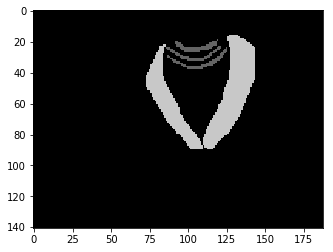

In [54]:
img_c = cv2.imread(str(get_image_files(path_img)[203]))
img = cv2.imread(str(get_image_files(path_lbl)[55]))
# img = resize(img, (500,500),anti_aliasing=True)

# fig=plt.figure(figsize=(8, 8))
# fig.add_subplot(1)

# plt.imshow(img*100)
# blur_img = cv2.blur(img, (3,3))
# plt.subplot(1,1)
plt.imshow(img*100)

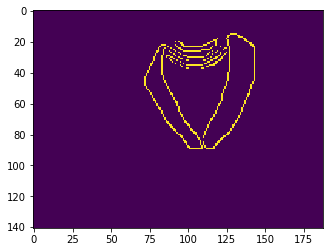

In [6]:
edges = cv2.Canny(img, 1,1)
plt.imshow(edges)

# Blob (Instance) Detection

In [1]:
from skimage import measure
from skimage import filters
import matplotlib.pyplot as plt
import numpy as np
from skimage import img_as_float, img_as_uint, img_as_int, img_as_ubyte
from scipy import ndimage

In [2]:
num_classes = 4 #everything_else, vocal_cords, tracheal_rings, bifurcation

In [3]:
def get_blobs(img, imshow=False):
    img2 = img_as_ubyte(np.array(img))
#     print(img2.shape)

    #each channel in sep_classes contains a given class of labels. sep_blobs[i].shape is (img.width,img.height,num_classes)
    sep_classes = []
    for i in range (0,num_classes):
        sep_classes.append( np.array(img2 == i ).astype(np.uint) )
        

    blobs_labels = [measure.label(blobs, background=0)[:,:,0] for blobs in sep_classes]

    plt.figure(figsize=(9, 3.5))

    if imshow:
        for i in range(1,num_classes):
#             plt.axis('off')
            plt.subplot(130+i)
            plt.imshow(blobs_labels[i]*100, cmap='nipy_spectral')
            plt.title(str(i))

#         plt.axis('off')
        plt.tight_layout()
        plt.show()
        
    return blobs_labels

Let's find blobs on a video

In [6]:
import sys
from fastai.vision import *
from fastai.vision import Image
from fastai.callbacks.hooks import *
from fastai.utils.mem import *
import cv2
from matplotlib import pyplot as plt
import numpy as np
import PIL
from skimage.transform import resize
from skimage import img_as_float, img_as_uint, img_as_int, img_as_ubyte
from IPython.display import clear_output
import time

In [7]:
################################################
learn = None
cap = None
out = None

path = Path('/storage')
path_lbl = path/'vocal_cords_and_rings_data/data/labels'
path_img = path/'vocal_cords_and_rings_data/data/images'
path_lbl = path_lbl.resolve()
path_img = path_img.resolve()
################################################
get_y_fn = lambda x: path_lbl/f'{x.stem}{x.suffix}'

codes = np.loadtxt(path_lbl/'../../codes.txt', dtype=str);
bs = 4

src = (SegmentationItemList.from_folder(path_img)
        .split_by_fname_file('../../valid.txt')
        .label_from_func(get_y_fn, classes=codes))
data = (src.transform(get_transforms(flip_vert=True), size=224, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

learn = unet_learner(data, models.resnet101);
learn.load('stage-2-big-0614-rn101');
################################################

In [8]:
def crop_img(img,cropx,cropy):
    cropx=np.min(img.shape[:2])
    cropy=cropx
    y,x = img.shape[:2]
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return resize(img[starty:starty+cropy,startx:startx+cropx], (224,224),anti_aliasing=True) #dtype = float64
################################################
def mask_to_colour(mask,colour=[0,255,0]):
    output_mask = np.zeros((mask.shape[0],mask.shape[1],3)).astype(np.uint8)
    green = [0,255,0]
    red = [255,0,0]
    blue = [0,0,255]
    other = [150,200,0]
    output_mask[mask==1]=red
    output_mask[mask==2]=green
    output_mask[mask==3]=blue
    return output_mask

#Swaps the r and b channels, for converting between PIL Image and Opencv BGR nparray
def red_blue_swap(img):
    return img[:, :, ::-1]
################################################

In [10]:
cap = cv2.VideoCapture('/storage/vocal_cords_and_rings_data/nbs/20181010_12y_5031752 mild subglottic stenosis uneditted.mpg')
# out = cv2.VideoWriter('/storage/vocal_cords_and_rings_data/data/videos/output_polar_blobs.avi',cv2.VideoWriter_fourcc('M','J','P','G'), 30.0, (224,224))
print ("Cap fps: {}".format(cap.get(cv2.CAP_PROP_FPS)))
ctr = 0

######PARAMS######
#fps of the input video
fps=30
#start time for annotation (in seconds)
start_time_s= 45
#end time for annotation (in seconds)
end_time_s = 54
mask_timeline = []
clean_timeline = []
clean_flattened_timeline = []
frame_timeline = []
eroded_timeline = []
###ENDOF PARAMS###

Cap fps: 29.97002997002997


In [11]:
#Advance to starting frame
for i in range(0,start_time_s*fps):
    ret, frame = cap.read()
    ctr+=1
    
clear_output()
print ("Starting!")
while(cap.isOpened() and ctr <end_time_s*fps):

    ctr+=1
    print(ctr)
    
    ret, frame = cap.read() #frame is uint8
    if np.shape(frame) == (): #i.e. empty frame
        break

            
    #Convert from OpenCV image to pytorch tensor, to Image
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB) #frame_rgb is uint8
    
    t = PIL.Image.fromarray(frame_rgb)
    t = pil2tensor(t.convert("RGB"), np.float32).div_(255)
    t = Image(t)
    
    #Predict
    prediction = learn.predict(t)
    p = prediction[1] #prediction data
    p1 = np.array(p)
    p1.astype('uint8')

    p3 = p1
    p3 = p3.squeeze()
    
    p4 = np.expand_dims(p3, axis=2)
    p4 = p4.astype('uint8')
    
    mask = np.copy(p4)
    mask=mask.squeeze()

    mask_d = mask_to_colour(mask)
    mask_d = img_as_float(mask_d)
    
    mask_timeline.append(mask)
#     plt.imshow(mask_d)
#     plt.show()
    
    ########################## NEW STUFF #################################
    img = mask.copy()
    img = img.astype(np.float32)

    #img.shape[0]/2, img.shape[1]/2
    #360,350
    
    ####### Find centroid of bifurcation#####
    mask = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
    labels = get_blobs(mask,imshow=False)
    thresh = labels[3]
    thresh = img_as_uint(thresh*100)

    if len(np.where( thresh > 0 )[0]):
        # calculate moments of binary image
        M = cv2.moments(thresh)
        # calculate x,y coordinate of center
        cX = int(M["m10"] / M["m00"])
        cY = int(M["m01"] / M["m00"])
    else:
        cX = 125
        cY = 150
        
    ###### endof find centre ############
    


    value = np.sqrt(((img.shape[0]/2.0)**2.0)+((img.shape[1]/2.0)**2.0))
    polar_image = cv2.linearPolar(img,(cX,cY), value, cv2.WARP_FILL_OUTLIERS)
    polar_image = polar_image.astype(np.uint8)

    # plot_many([_,mask_timeline[71],polar_image])
#     plot_many([_,img,polar_image])
    e_list = []
    for num in range(5,12):
        e = cv2.erode(polar_image,np.ones((num,1)))
        e_list.append(e)
    eroded_timeline.append(e_list)
#     e = cv2.erode(e,np.ones((2,2)))

    e = cv2.erode(polar_image,np.ones((11,1)))
    clean_flattened_timeline.append((e,(cX,cY)))
#     plt.imshow(e)
#     plt.show()
    linear_image = cv2.linearPolar(clean_flattened_timeline[-1][0],(cX,cY), value, cv2.WARP_INVERSE_MAP+cv2.WARP_FILL_OUTLIERS)
    clean_timeline.append(linear_image)
    
    frame_rgb =crop_img(frame_rgb,None,None)
    frame_rgb = cv2.linearPolar(frame_rgb,(cX,cY), value, cv2.WARP_FILL_OUTLIERS)
#     frame_rgb = frame_rgb.astype(np.uint8)
    frame_timeline.append(frame_rgb)
    
    print(ctr)
    clear_output(wait=True)
#     plt.imshow(frame_rgb)
#     plt.show()
    
#     plt.imshow(linear_image)
#     plt.show()
    
#     cr=crop_img(frame,224,224) #cr is float64
    
#     #Save the overlaid frame
#     ov=overlay_mask(cr, mask_d)
    
#     # Write uint8 version of ov to output video
    print(e.shape)
#     plt.imshow(e)
#     out.write(cv2.cvtColor(e*100, cv2.COLOR_GRAY2BGR))
    
cap.release()
# out.release()
print ("End!")

(224, 224)
End!


<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

<Figure size 648x252 with 0 Axes>

In [9]:
# out.release()

# Tracking

(224, 224)

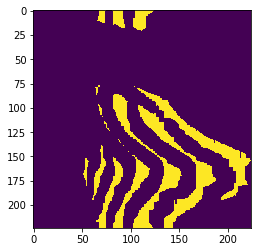

In [18]:
plt.imshow(clean_flattened_timeline[71][0]==1)
clean_flattened_timeline[71][0].shape

In [19]:
import imutils

def plot_many(images):
    plt.figure(figsize=(9, 3.5))

    
    for i in range(1,len(images)):
#             plt.axis('off')
        plt.subplot(130+i)
        plt.imshow(images[i], cmap='nipy_spectral')
        plt.title(str(i))

#         plt.axis('off')
    plt.tight_layout()
    plt.show()


def sort_contours(cnts, method="left-to-right"):
    # initialize the reverse flag and sort index
    reverse = False
    i = 0

    # handle if we need to sort in reverse
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True

    # handle if we are sorting against the y-coordinate rather than
    # the x-coordinate of the bounding box
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1

    # construct the list of bounding boxes and sort them from top to
    # bottom
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),key=lambda b:b[1][i], reverse=reverse))

    # return the list of sorted contours and bounding boxes
    return (cnts, boundingBoxes)



def draw_contour(image, c,bbox, i):
    # compute the center of the contour area and draw a circle
    # representing the center
#     M = cv2.moments(c)
#     cX = int(M["m10"] / M["m00"])
#     cY = int(M["m01"] / M["m00"])
    x,y,w,h = bbox
    cX = x+25#+w/2.0
    cY = y+10#+h/2.0
    
    # draw the countour number on the image
    cv2.putText(image, "#{}".format(i + 1), (cX - 20, cY), cv2.FONT_HERSHEY_SIMPLEX,
        0.3, (255, 255, 255), 1)

    # return the image with the contour number drawn on it
    return image

In [20]:
def contiguous_regions(condition):
    """Finds contiguous True regions of the boolean array "condition". Returns
    a 2D array where the first column is the start index of the region and the
    second column is the end index."""

    # Find the indicies of changes in "condition"
    d = np.diff(condition)
    idx, = d.nonzero() 

    # We need to start things after the change in "condition". Therefore, 
    # we'll shift the index by 1 to the right.
    idx += 1

    if condition[0]:
        # If the start of condition is True prepend a 0
        idx = np.r_[0, idx]

    if condition[-1]:
        # If the end of condition is True, append the length of the array
        idx = np.r_[idx, condition.size] # Edit

    # Reshape the result into two columns
    idx.shape = (-1,2)
    return idx

def longest_contiguous_region(condition):
    region = (0,0) # (start,stop)
    longest = (0,0)
    for start, stop in contiguous_regions(condition):
        segment = histogram[start:stop]
        if len(segment) > longest[1]-longest[0]:
            region = (start,stop)
    #     print start, stop
    #     print segment.min(), segment.max()
    centrepoint = int((region[0]+region[1])/2)
    return region, centrepoint

### Let's try using a vertical histogram to track the features

(1, 224, 3)
(224, 224, 3)
float64 float64


/opt/conda/envs/fastai/lib/python3.6/site-packages/scikit_image-0.15.0-py3.6-linux-x86_64.egg/skimage/util/dtype.py:135: UserWarning: Possible precision loss when converting from uint64 to float64
  .format(dtypeobj_in, dtypeobj_out))


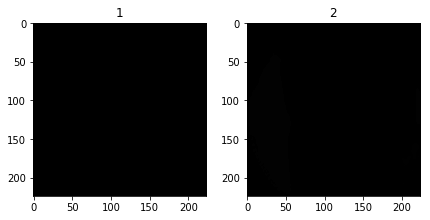

In [14]:
# plt.imshow(np.expand_dims(histogram, axis=0))

histogram_v = np.sum((mask==1).astype(np.uint8), axis=0)#row-wise sums

hist_img = np.expand_dims(histogram_v, axis=0)
print(hist_img.shape)
hist_img = resize(hist_img,(224, 224),anti_aliasing=True)
print(hist_img.shape)

# resize(img, (500,500),anti_aliasing=True)
print(hist_img.dtype, img_as_float(mask).dtype)
plot_many([_,hist_img,img_as_float(mask)])

# Print the start and stop indicies of each region where the absolute 
# values of x are below 1, and the min and max of each of these regions


## Tests with watershed

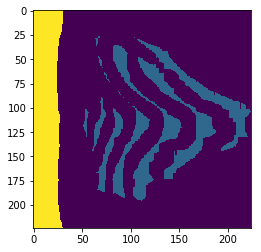

In [23]:
plt.imshow(mask_continuous_timeline[0])

In [21]:
def pltimg(img):
    plt.imshow(img)
    plt.show()

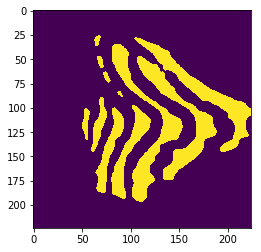

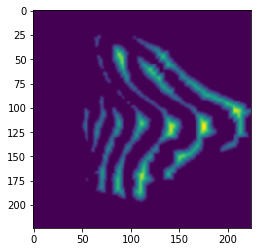

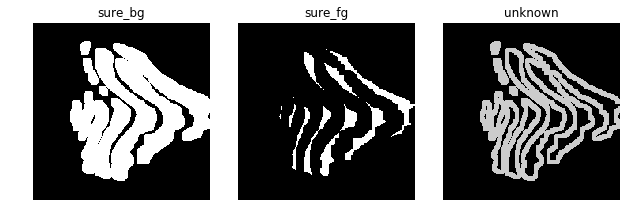

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

from skimage.morphology import watershed
from skimage.feature import peak_local_max

mask = mask_continuous_timeline[0]
img_og = mask
image = ((mask==1)*100).copy()
image = image.astype(np.uint8)

# pltimg(image)
# print("original")

kernel = np.ones((3,3),np.uint8)
image = cv2.dilate(image, kernel)
opening = cv2.morphologyEx(image,cv2.MORPH_OPEN,kernel, iterations = 1)
# pltimg(opening)

# print("opening")

image = cv2.erode(image, kernel)
image = cv2.dilate(image, kernel)

image = cv2.blur(image,(5,5))
# pltimg(image)

ret, thresh = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

pltimg(thresh)

#thresh is super clean
image = thresh

#finding sure background
sure_bg = cv2.dilate(image,kernel,iterations=3)
# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_C,0)
pltimg(cv2.blur(dist_transform,(3,3)))
ret, sure_fg = cv2.threshold(dist_transform,0.3*dist_transform.max(),255,0)
# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)


fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(sure_bg, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('sure_bg')
ax[1].imshow(sure_fg, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('sure_fg')
ax[2].imshow(unknown, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[2].set_title('unknown')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

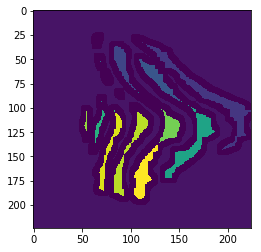

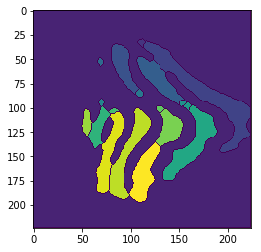

In [205]:
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)
# Add one to all labels so that sure background is not 0, but 1
markers = markers+1
# Now, mark the region of unknown with zero
markers[unknown==255] = 0
pltimg(markers)

i = cv2.cvtColor(img_og, cv2.COLOR_GRAY2BGR)
markers = cv2.watershed(i,markers)
output_mask = np.zeros((mask.shape[0],mask.shape[1],3)).astype(np.uint8)
output_mask[markers==-1] = [0,255,0]
pltimg(markers)

Labels: [0 1]


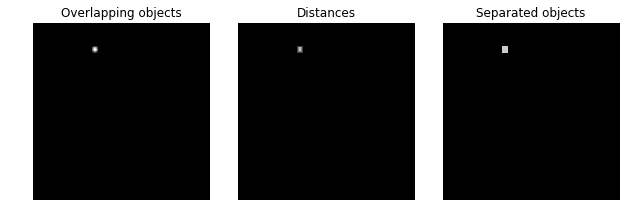

In [206]:
# Now we want to separate the two objects in image
# Generate the markers as local maxima of the distance to the background
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((3, 3)),
                            labels=image)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)
print("Labels: {}".format(np.unique(labels)))
# labels = labels==20

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray, interpolation='nearest')
ax[0].set_title('Overlapping objects')
ax[1].imshow(distance, cmap=plt.cm.gray, interpolation='nearest')
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral, interpolation='nearest')
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()

## Finding the posterior region

In [16]:
mask_continuous_timeline = []

In [17]:
# tracker = cv2.MultiTracker_create()
area_thresh = 40
colors = [] 
colors.append((0,255,0))
 
# OpenCV's selectROI function doesn't work for selecting multiple objects in Python
# So we will call this function in a loop till we are done selecting all objects
# while True:
#   # draw bounding boxes over objects
#   # selectROI's default behaviour is to draw box starting from the center
#   # when fromCenter is set to false, you can draw box starting from top left corner
#   bbox = cv2.selectROI('MultiTracker', frame)
#   bboxes.append(bbox)
#   colors.append((randint(0, 255), randint(0, 255), randint(0, 255)))
#   print("Press q to quit selecting boxes and start tracking")
#   print("Press any other key to select next object")
#   k = cv2.waitKey(0) & 0xFF
#   if (k == 113):  # q is pressed
#     break

# bboxes = []
# im = np.zeros((224,224,3), np.uint8)

# _, contours, _ = cv2.findContours(clean_flattened_timeline[71]*100, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)#RETR_LIST


###Remove this after
# c = contours[14]
# print("contours length: {}".format(contours))

# for c in contours:
##remove after
# c = contours[8]
# ##endof remove after

# rect = cv2.boundingRect(c)
# #     if rect[2] * rect[3] < 100: continue
# # print (cv2.contourArea(c))
# x,y,w,h = rect
# cv2.rectangle(im,(x,y),(x+w,y+h),(0,255,0),2)
# cv2.drawContours(im, [c], -1, (255,0, 0), 2)
# bboxes.append(rect)

# plt.imshow(im)
# plt.show()

##########contour sorting###########
tracker = cv2.TrackerGOTURN_create()
#Get first contours for a bbox
cnts = cv2.findContours(clean_flattened_timeline[71][0]*100, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
(cnts, boundingBoxes) = sort_contours(cnts)
#endof get first contours for a bbox
ret = tracker.init(frame_timeline[71],boundingBoxes[6])
cloned = clean_flattened_timeline[71][0].copy()
x,y,w,h =  boundingBoxes[8]
cv2.rectangle(cloned,(x,y),(x+w,y+h),(0,255,0))
plt.imshow(cloned)
plt.show()
# time.sleep(3)

ctr = 0
prev_posterior_angles = [math.pi/2,math.pi/2,math.pi/2,math.pi/2]#circular buffer to calculate avg
for mask, frame in zip(clean_flattened_timeline[71:], frame_timeline[71:]):
    mask = mask[0]
    ctr+=1
    cnts = cv2.findContours(mask*100, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    
    # Keep only large contours
#     cnts_l = []
#     for c in cnts:
#         if cv2.contourArea(c)>area_thresh:
#             cnts_l.append(c)


#     orig = mask.copy()
#     orig*=10013
    orig = frame.copy()
    
    # sort the contours according to the provided method
    (cnts, boundingBoxes) = sort_contours(cnts)

    # loop over the (now sorted) contours and draw them
#     cv2.drawContours(orig, cnts, -1, (0, 255, 0), 2)
    for (i, c) in enumerate(cnts):
        draw_contour(orig,c,boundingBoxes[i], i)
        if True:
#             orig = cv2.cvtColor(orig, cv2.COLOR_GRAY2BGR)
            x,y,w,h = boundingBoxes[i]
            cv2.rectangle(orig,(x,y),(x+w,y+h),(0,255,0),2)

    ##TRACKING
#     print(mask.shape)
#     blob = cv2.dnn.blobFromImage(np.array([mask,mask,mask,mask]))
#     print(blob.dtype)
    
#     ok,box = tracker.update(np.float32(frame))

        
    # Find anterior and posterior parts
    histogram = np.sum((mask==1).astype(np.uint8), axis=1)#row-wise sums
    region, posterior = longest_contiguous_region(histogram < 5)
#     print(posterior)#posterior is the row (i.e. angle in polar notation) of the centre of posterior region
    posterior_angle = posterior*(2*math.pi/mask.shape[0])
    prev_posterior_angles[ctr%len(prev_posterior_angles)]=posterior_angle
    posterior_angle = np.average(prev_posterior_angles)
    print("Posterior angle: {} from {}".format(posterior_angle,posterior))
    
    frame_copy = frame.copy()
    frame_copy = cv2.linearPolar(img_as_float(frame_copy),(cX,cY), math.sqrt(value**2+value**2), cv2.WARP_INVERSE_MAP+cv2.WARP_FILL_OUTLIERS)
    centreX, centreY = frame.shape[0]/2.0, frame.shape[1]/2.0

    L1 = 75
    L2 = 100
#     posterior_angle *= -1
    p1 = np.round((centreX+L1*math.cos(posterior_angle),centreY+L1*math.sin(posterior_angle))).astype(np.int)
    p2 = np.round((centreX+L2*math.cos(posterior_angle),centreY+L2*math.sin(posterior_angle))).astype(np.int)
#     frame_copy = img_as_uint(frame_copy)
    cv2.arrowedLine(frame_copy, tuple(p1),tuple(p2), (255,0,0),3)
    
    temp = mask[0:posterior,0:]
    mask_continuous = np.concatenate((mask[posterior:,0:],temp))
    mask_continuous_timeline.append(mask_continuous)
#     plt.imshow(mask_continuous)
#     plt.show()

    
    #show the output image
    print(ctr)
    
#     plt.imshow(mask_continuous)
#     plt.imshow(frame_copy)
#     plt.imshow(cv2.linearPolar(img_as_float(frame_copy),(cX,cY), math.sqrt(value**2+value**2), cv2.WARP_INVERSE_MAP+cv2.WARP_FILL_OUTLIERS))
#     plot_many([_,orig,cv2.linearPolar(img_as_float(frame_copy),(cX,cY), math.sqrt(value**2+value**2), cv2.WARP_INVERSE_MAP+cv2.WARP_FILL_OUTLIERS)])
    plt.show()
    time.sleep(1)
    clear_output(wait=True)
#####################

# Create MultiTracker object
# multiTracker = cv2.MultiTracker_create()
 
# Initialize MultiTracker 
# for bbox in bboxes:
#     multiTracker.add(cv2.TrackerCSRT_create(), clean_flattened_timeline[71], bbox)

ValueError: not enough values to unpack (expected 2, got 0)

In [207]:
fig=plt.figure(figsize=(24,24))
columns = 3
rows = 3

# for c in range (71,100):
for i in range(1, min(columns*rows +1, len(eroded_timeline[0])+1)):
    img = eroded_timeline[c][i%7]
    img = cv2.linearPolar(img_as_float(img),(cX,cY), math.sqrt(value**2+value**2), cv2.WARP_INVERSE_MAP+cv2.WARP_FILL_OUTLIERS)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
#     clear_output()
plt.show()
#     plt.imshow(cv2.linearPolar(img_as_float(mask),(cX,cY), math.sqrt(value**2+value**2), cv2.WARP_INVERSE_MAP+cv2.WARP_FILL_OUTLIERS))

TypeError: only integer scalar arrays can be converted to a scalar index

<Figure size 1728x1728 with 0 Axes>

In [31]:
len(mask_continuous_timeline)

152

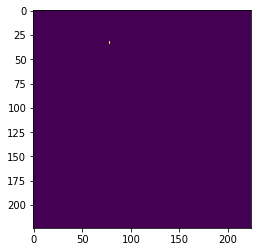

In [34]:
for frame in mask_continuous_timeline:
    clear_output(wait=True)
#     print(ctr)
    plt.imshow(frame)
    plt.show()

<function matplotlib.pyplot.show(*args, **kw)>

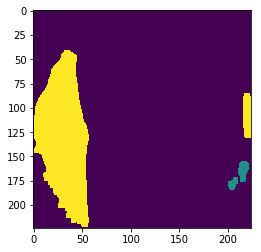

In [11]:
mask_c = cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR)
plt.imshow(cv2.cvtColor(mask,cv2.COLOR_GRAY2BGR))
# plt.imshow(mask_c*100.0)

mask_dilate = np.zeros_like(mask)
mask_dilate = cv2.erode(mask,np.ones((3,3)))
mask_dilate = cv2.dilate(mask_dilate,np.ones((5,5)))
plt.imshow(mask_dilate)
plt.show

# labels = get_blobs(mask_c,imshow=True)
# one_ring = np.array(labels[1]==10)
# plt.imshow(one_ring)
# ndimage.measurements.center_of_mass(one_ring)

[0 1 3]
(224, 224, 3)
stuff in [2] [0 1]


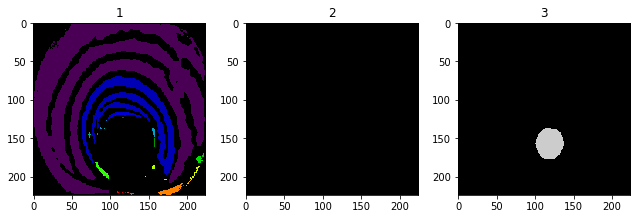

In [168]:
img = cv2.cvtColor(mask_timeline[71],cv2.COLOR_GRAY2BGR)
print(np.unique(img))
labels = get_blobs(img,imshow=True)

[0 1]
[[0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 ...
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]
 [0 0 0 0 ... 0 0 0 0]]
(118, 156)


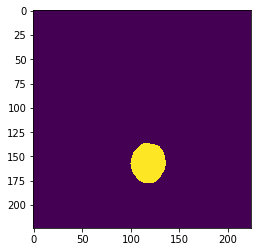

In [179]:
plt.imshow(labels[3])

thresh = labels[3]
 
print(np.unique(thresh))
thresh = img_as_uint(thresh*100)
print(thresh)
# convert the grayscale image to binary image
# ret,thresh = cv2.threshold(gray_image,127,255,0)
 
# calculate moments of binary image
M = cv2.moments(thresh)
 
# calculate x,y coordinate of center
cX = int(M["m10"] / M["m00"])
cY = int(M["m01"] / M["m00"])

print((cX,cY))

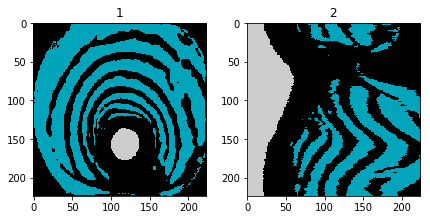

In [30]:
# targ = cv2.imread("/storage/vocal_cords_and_rings_data/data/target3.PNG")
# plt.imshow(targ)

############################
# img = targ
img = mask_timeline[71]
img = img.astype(np.float32)
# img = cv2.resize(img,(240,190))

#img.shape[0]/2, img.shape[1]/2
#360,350

# value = np.sqrt(((img.shape[0]/2.0)**2.0)+((img.shape[1]/2.0)**2.0))
value = img.shape[0]/2.0
polar_image = cv2.linearPolar(img,(cX,cY), value, cv2.WARP_FILL_OUTLIERS)
polar_image = polar_image.astype(np.uint8)

# plot_many([_,mask_timeline[71],polar_image])
plot_many([_,img,polar_image])

[0 1 3]


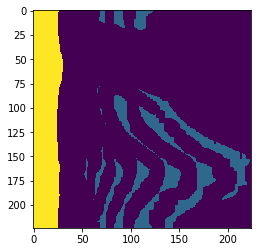

In [213]:
e = cv2.erode(polar_image,np.ones((11,1)))
e = cv2.erode(e,np.ones((2,2)))

plt.imshow(e)
print(np.unique(e))

[0 1 3]
1


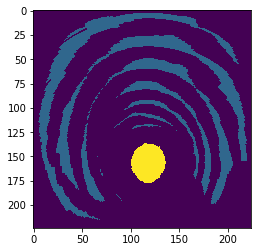

In [214]:
linear_image = cv2.linearPolar(e,(cX,cY), value, cv2.WARP_INVERSE_MAP+cv2.WARP_FILL_OUTLIERS)
plt.imshow(linear_image)
print(np.unique(linear_image))
print(linear_image[cX,cY])

[0 1 3]
(224, 224, 3)
stuff in [2] [0 1]


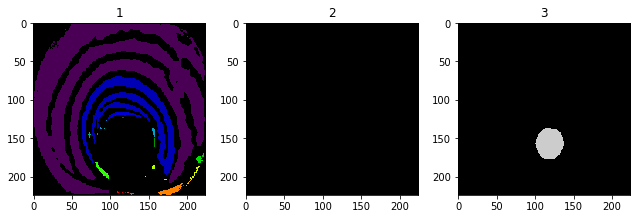

[[1 1 1 1 ... 1 1 1 1]
 [1 1 1 1 ... 1 1 1 1]
 [1 1 1 1 ... 1 1 1 1]
 [1 1 1 1 ... 1 1 1 1]
 ...
 [4 4 4 4 ... 4 4 4 4]
 [4 4 4 4 ... 4 4 4 4]
 [4 4 4 4 ... 4 4 4 4]
 [4 4 4 4 ... 4 4 4 4]]
[0 1 3]
(224, 224, 3)
stuff in [2] [0 1]


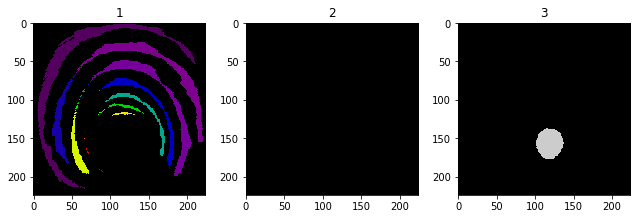

4


In [221]:
img = cv2.cvtColor(mask_timeline[71],cv2.COLOR_GRAY2BGR)
print(np.unique(img))
labels = get_blobs(img,imshow=True)

img = cv2.cvtColor(linear_image,cv2.COLOR_GRAY2BGR)
print(np.unique(img))
labels = get_blobs(img,imshow=True)

In [118]:
# print(cv2.cvtColor(labels[1],cv2.COLOR_GRAY2BGR).shape)
from imutils import perspective
from imutils import contours
import imutils

# edged = cv2.Canny(img*100, 50, 100)
# edged = cv2.dilate(edged, None, iterations=1)
# edged = cv2.erode(edged, None, iterations=1)

cnts = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
 
# sort the contours from left-to-right and initialize the
# 'pixels per metric' calibration variable
(cnts, _) = contours.sort_contours(cnts)


5


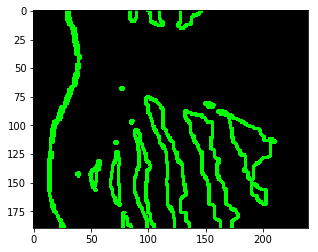

In [119]:
large_cnts=[]
for c in cnts:
    if cv2.contourArea(c) > 30:
        large_cnts.append(c)
print(len(large_cnts))
orig = np.zeros_like(img)
cv2.drawContours(orig, [l for l in cnts], -1, (0, 255, 0), 2)
plt.imshow(orig)
# plot_many([cv2.drawContours(orig, l, -1, (0, 255, 0), 2) for l in cnts][:2])

## Skelletised to polar

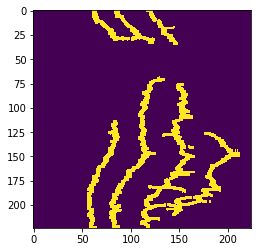

In [139]:
## skel = cv2.imread('/storage/vocal_cords_and_rings_data/data/skelletised.png', cv2.IMREAD_GRAYSCALE)
# plt.imshow(skel)
polar_skel = cv2.linearPolar(skel,(cX,cY-20), value, cv2.WARP_FILL_OUTLIERS)
polar_skel = cv2.threshold(cv2.blur(polar_skel,(1,3)),0,255,cv2.THRESH_BINARY)[1]
plt.imshow(polar_skel)
# plt.imshow()

## Tracking from scratch

TODO: Implement blob wise intersection. The corresponding blobs in frame t+1 will be the one that the current blob has the largest intersection with.

Should really work. Try!

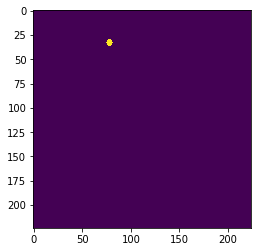

In [58]:
# Erode/dilate/blur/thresh ring mask to make the edges smooth, and attempt to eliminate unwanted connections between rings
clean_blobs = []
for mask in mask_continuous_timeline:   
    img_og = mask
    image = ((mask==1)*100).copy()
    image = image.astype(np.uint8)

    # pltimg(image)
    # print("original")

    kernel = np.ones((3,3),np.uint8)
    image = cv2.dilate(image, kernel)
    opening = cv2.morphologyEx(image,cv2.MORPH_OPEN,kernel, iterations = 1)
    # pltimg(opening)

    # print("opening")

    image = cv2.erode(image, kernel)
    image = cv2.dilate(image, kernel)

    image = cv2.blur(image,(5,5))
    # pltimg(image)

    ret, thresh = cv2.threshold(image,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)

    pltimg(thresh)
    clear_output(wait=True)

    #thresh is super clean
    clean_blobs.append(thresh)

In [36]:
def get_blobs_single_class(img, label_value):
    blobs = measure.label(np.array(img_as_ubyte(np.array(img)) == label_value).astype(np.uint) )
    independent_blobs = []
    for i in np.unique(blobs)[1:]:
        single_blob = np.zeros_like(blobs)
        single_blob[blobs==i]=255
        independent_blobs.append(single_blob)
    return independent_blobs

In [216]:
'''
constraints:

0) children can only have one parent. parents can have multiple children

1) children must have a large enough intersection with their parent

2) children must be smaller than their parents (they are allowed to be larger up to a certain threshold)
if a potential child has a strong correlation to a given potential parent (large intersection), it is only
considered a child if child_area < parent_area*thresh (where thresh is >= 1)
else if a potential child has a strong correlation to a given potential parent, and it doesn't meet the area criteria,
a new track is created for it and it is parentless (TODO: consider going "back" in the tree and grouping previous blobs
and considering them as a single blob so that the area criteria is met. rn thinking not needed)



'''
def blob_area(bin_img):
    return len(np.where(bin_img>0)[0])

def correlate_blobs(new_blobs, prev_blobs, percent_overlap_thresh=0.75, child_area_thresh=1.2):
    parent_to_children = {} #key is the parent ID, value is the child ID
    orphans = [] # IDs of blobs without parents
    
    #Make all children empty lists
    for p in range(0, len(prev_blobs)):
        parent_to_children[p] = [] 
    
    #Populate parent_to_child dict (children pick their parents)
    for c in range(0, len(new_blobs)):
        nblob = new_blobs[c]
   
        max_intercept = 0
        
#         parent_to_children[p] = []
                        
        for p in range(0,len(prev_blobs)):
            pblob = prev_blobs[p]
            intersect = cv2.bitwise_and(nblob, pblob)
            
            if blob_area(intersect) > max_intercept:
                max_intercept = blob_area(intersect)
                if blob_area(nblob) < blob_area(pblob)*child_area_thresh:
                    parent_to_children[p].append(c) #Huzzah! Child picked a parent
                else: #Child has no parent
                    orphans.append(c)
                    
    #Join children blobs (if they belong to the same parent) to deal with blob separation
    #and add (child,parent) tuple to a "family" list
#     joined_blobs = {} # len(new_blobs) == len(prev_blobs)+len(orphans)
    family = []
    
    for p in range (0, len(parent_to_children)):
#         joined_blobs[p] = []
        if len(parent_to_children[p])>1: #parent has more than one child
            joined_blob = np.zeros_like(prev_blobs[0])
            for child_blob_index in parent_to_children[p]:
                joined_blob = cv2.bitwise_or(new_blobs[child_blob_index], joined_blob)
#                 print("joined_blobs shape: {}".format(joined_blob.shape))
#             joined_blobs[p].append(joined_blob)
            family.append((joined_blob,prev_blobs[p]))
            
        elif len(parent_to_children[p])==1:
            joined_blob = new_blobs[parent_to_children[p][0]]
#             joined_blobs[p].append(joined_blob)
            family.append((joined_blob,prev_blobs[p]))
        else: #do nothing -> i.e. a parent that didn't have a child will die
            family.append((np.zeros_like(prev_blobs[p]),prev_blobs[p]))
    
    #Add orphans to the future parents list, so they can have children
    orphans = []
    for o in orphans:
#         joined_blobs[len(parent_to_children) + o] = []
#         joined_blobs[len(parent_to_children) + o].append(new_blobs[o])
        orphans.append((new_blobs[o], None))
        
    
    return family, orphans #joined_blobs has prev_parents+orphans number of channels, each channel being an individual blob

In [288]:
def collapse_all_channels(blobs_new):
    blobs_new_frame = np.zeros_like(blobs_new[0][0])
    for b in blobs_new:
        blobs_new_frame = np.array(blobs_new_frame) | np.array(b[0])
    return blobs_new_frame

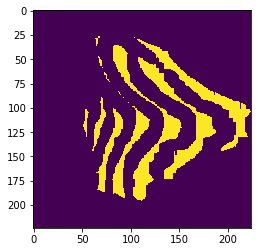

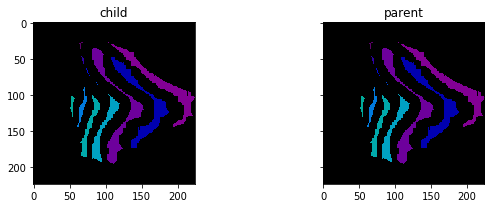

1


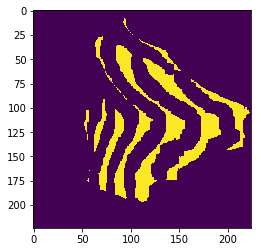

/opt/conda/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


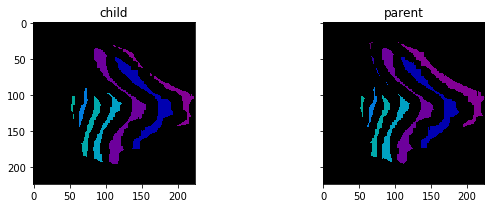

2


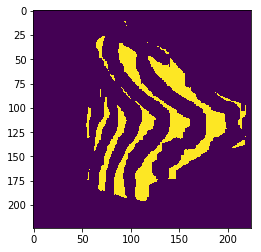

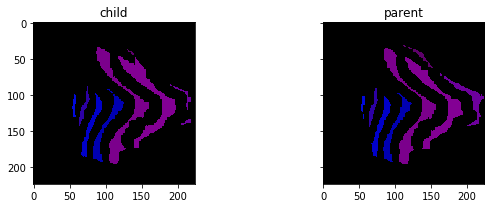

3


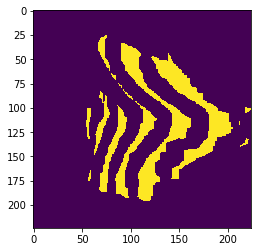

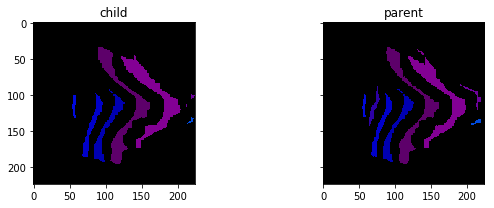

4


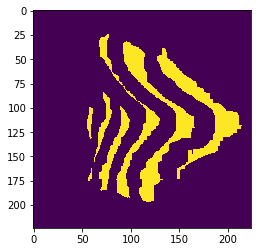

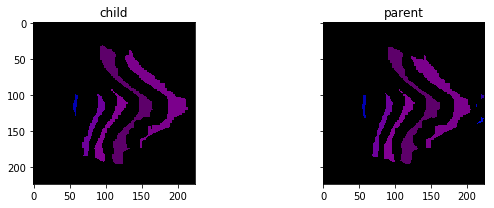

5


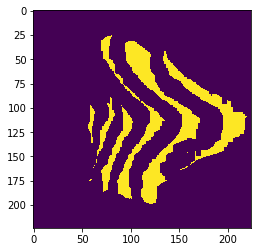

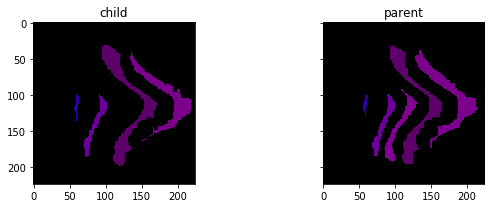

6


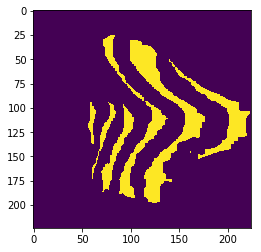

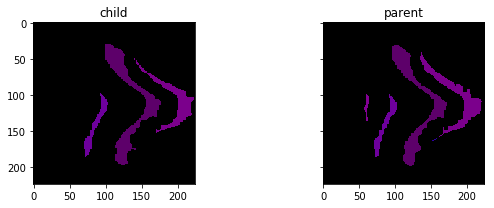

7


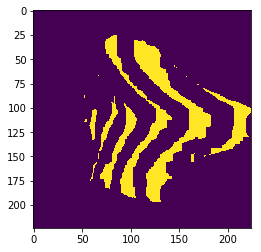

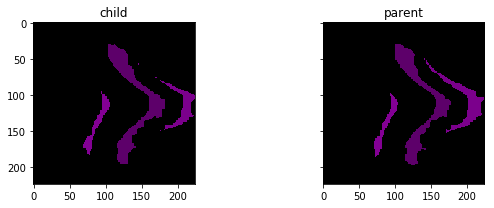

8


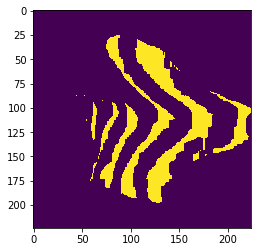

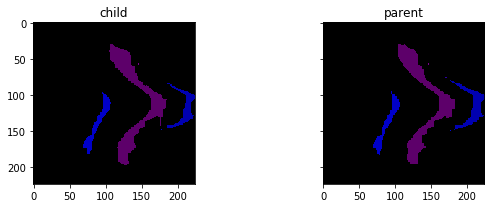

9


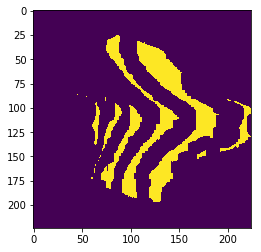

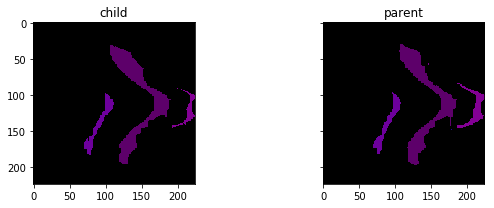

10


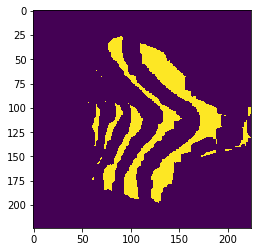

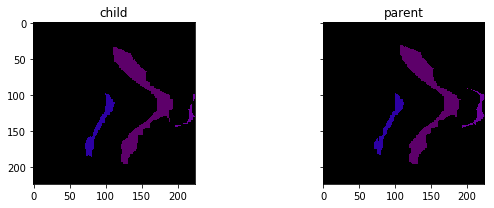

11


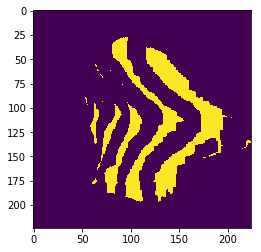

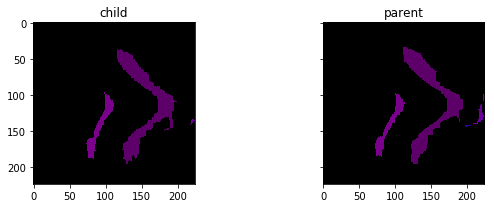

12


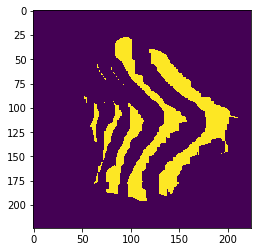

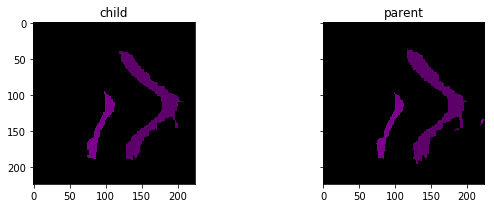

13


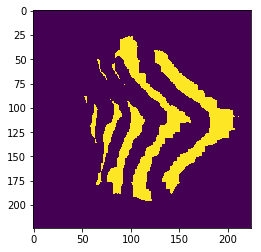

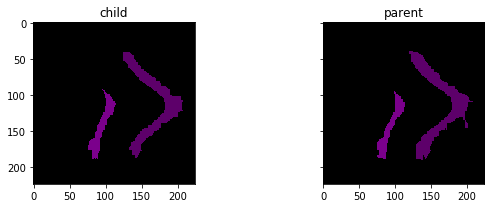

14


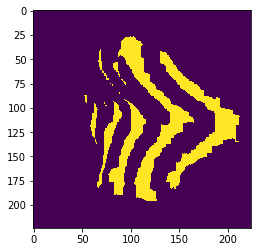

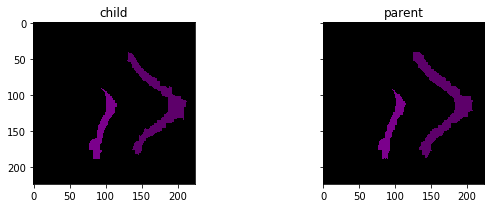

15


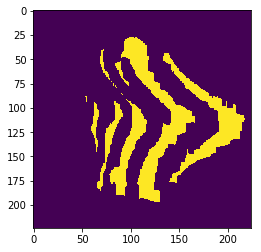

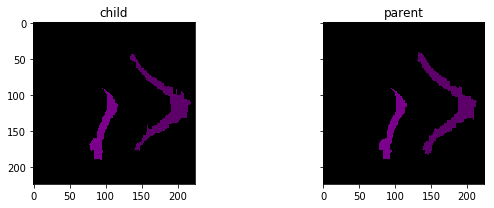

16


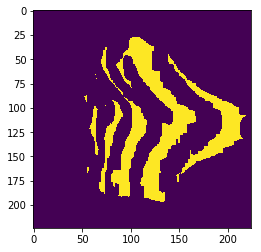

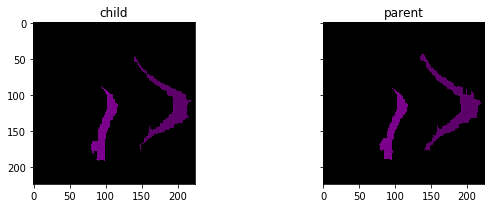

17


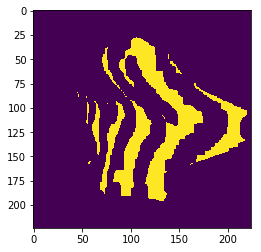

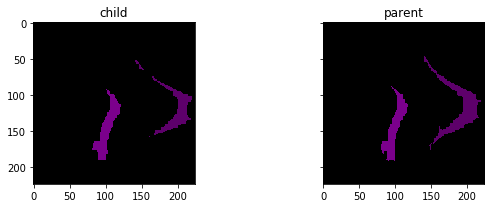

18


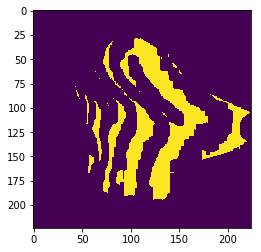

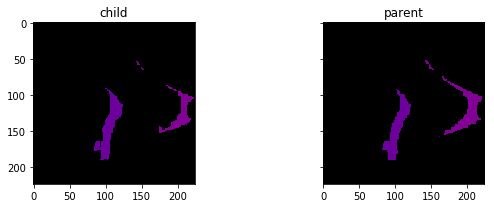

19


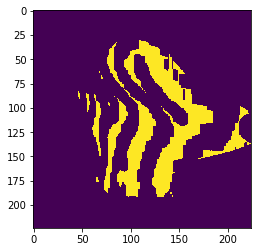

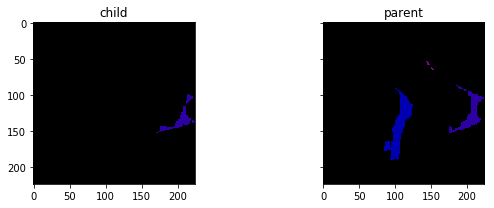

20


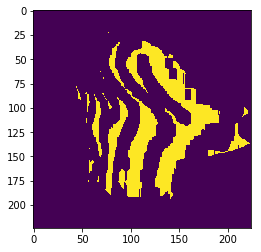

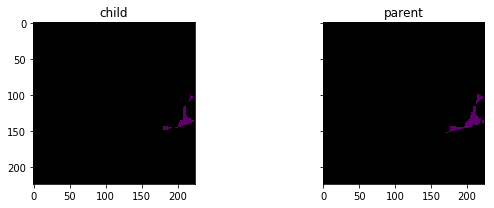

21


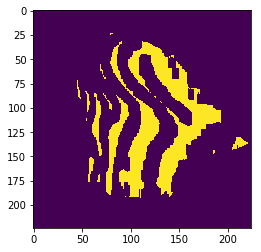

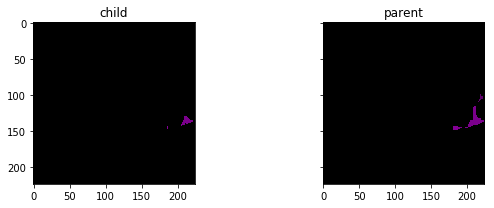

22


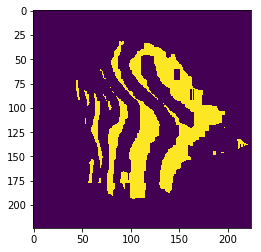

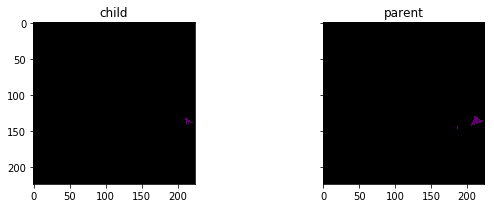

23


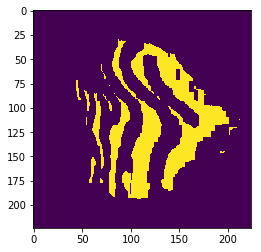

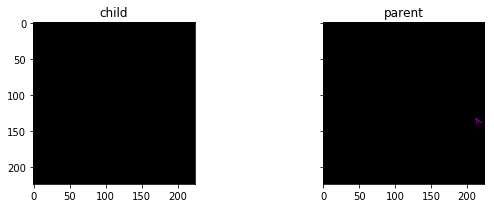

24


IndexError: list index out of range

In [293]:
verbose = False
prev_frame = mask_continuous_timeline[0]==1
blobs_prev = get_blobs_single_class(prev_frame, label_value=255)
cnt = 0

# for img in clean_blobs:
for img in mask_continuous_timeline:
    img = img==1
#     clear_output(wait=True)
#     print("counter: {}".format(cnt))
    cnt +=1
    
    #Find blobs
    blobs_current = get_blobs_single_class(img, label_value=255)
#     blobs_prev = get_blobs_single_class(prev_frame, label_value=255)
    
    #Correlate children to parent blobs
    # blobs_new has the joined blobs with indices corresponding to their parents
    blobs_new, orphans = correlate_blobs(blobs_current, blobs_prev)
    
    #Collapse all new blobs into a single frame to make it "prev_frame" for the next iteration
    blobs_new_frame = collapse_all_channels(blobs_new)
    
    blobs_prev = get_blobs_single_class(blobs_new_frame, label_value=255)
    
    pltimg(img)
    plot_blob_generations(blobs_new, orphans)
#     if cnt ==5:
#         break
    
    prev_frame = img
    
    if verbose:
#         plt.imshow(intersect)
#         plt.show()

        fig=plt.figure(figsize=(24,24))
        columns = 3
        rows = 1

        # for c in range (71,100):
        imgs = [intersect,img, img-intersect]
        for i in range(1, columns*rows +1):
            fig.add_subplot(rows, columns, i)
            plt.imshow(imgs[i-1])
        #     clear_output()
        plt.show()
    print(cnt)
#     time.sleep(0.5)
    
    

In [292]:
# pltimg(blobs_new[0][0])
# pltimg(blobs_new[0][1])

def plot_blob_generations(blobs_new, orphans, include_orphans=True):

    colours = np.linspace(10,249,40).astype(np.uint8)


    overlayed_children = np.zeros_like(blobs_new[0][0])
    overlayed_parents = np.zeros_like(blobs_new[0][0])


    fig, axes = plt.subplots(ncols=2, figsize=(9, 3), sharex=True, sharey=True)
    ax = axes.ravel()

    for (i,b) in enumerate(blobs_new):
        if len(np.unique(b[0])) > 0 :
            overlayed_children = (overlayed_children) | (b[0]/np.max(b[0])*colours[i]).astype(np.uint8)
        if len(np.unique(b[1])) > 0:
            overlayed_parents = (overlayed_parents) | (b[1]/np.max(b[1])*colours[i]).astype(np.uint8)
            
    if (include_orphans):
        for (i,b) in enumerate(orphans):
            overlayed_children = (overlayed_children) | (b[0]/np.max(b[0])*255).astype(np.uint8)
#             overlayed_parents = (overlayed_parents) | (b[1]/np.max(b[1])*colours[i]).astype(np.uint8)


    ax[0].imshow(overlayed_children, cmap='nipy_spectral', vmin=0, vmax=255)
    ax[0].set_title('child')
    ax[1].imshow(overlayed_parents, cmap='nipy_spectral', vmin=0, vmax=255)
    ax[1].set_title('parent')

    fig.tight_layout()
    plt.show()
